<a href="https://colab.research.google.com/github/krissivolga29-commits/analytics_big_data/blob/main/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация по тональности

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import bz2
import gdown
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import re
import regex
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
from string import punctuation
from tqdm import tqdm

from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics  import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Скачивание данных

In [ ]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:33, 2153.00it/s]


In [ ]:
size = len(responses)
size

153499

In [ ]:
# Посмотрим на пример отзыва:
responses[29]

{'city': 'г. Салават (Республика Башкортостан)',
 'rating_not_checked': False,
 'title': 'Нужен стационарный номер телефона офиса',
 'num_comments': 1,
 'bank_license': 'лицензия № 2562',
 'author': 'S_OM',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-05 19:02:55',
 'text': 'Здравствуйте, подскажите мне, пожалуйста, стационарный номер телефона офиса, который располагается в республике Башкортостан, г.Салават по адресу ул.Островского 13/32. Позвонила на горячую линию, мне там ответили, что у них нет контактного номера телефона, в интернете тоже не нашла, может здесь чем помогут?',
 'rating_grade': None}

# Часть 1. Анализ текстов

### 1.1 Посчитать количество отзывов в разных городах и на разные банки

In [ ]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [ ]:
# количество отзывов в разных городах
city_response = df['city'].value_counts()
city_response.head(10)

,count
city,
г. Москва,55354
г. Санкт-Петербург,14342
г. Екатеринбург,2337
г. Новосибирск,2300
г. Нижний Новгород,1976
г. Ростов-на-Дону,1891
г. Самара,1731
г. Челябинск,1507
г. Казань,1440


In [ ]:
# количество отзывов на разные банки
banks_response = df['bank_name'].value_counts()
banks_response.head(10)

,count
bank_name,
Сбербанк России,26327
Альфа-Банк,10224
ВТБ 24,8185
Русский Стандарт,7943
Хоум Кредит Банк,7549
Тинькофф Банк,5387
Национальный Банк «Траст»,4607
Ренессанс Кредит,3849
Связной Банк,3775


### 1.2 Построить гистограммы длин отзывов в символах и в словах

Подсчёт будем производить сразу исключая стоп-слова и пунктуацию

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
noise = stopwords.words('russian') + list(punctuation)

In [ ]:
vec_words = CountVectorizer(ngram_range=(1, 1), stop_words=noise)
bow_words = vec_words.fit_transform(df['text'])
vec_symbol = CountVectorizer(analyzer='char')
bow_symbol = vec_symbol.fit_transform(df['text'])

In [ ]:
ln_words = []
ln_symbol = []
for i in tqdm(range(size)):
    ln_words.append(np.sum(bow_words[i].todense()))
    ln_symbol.append(np.sum(bow_symbol[i].todense()))

100%|██████████| 153499/153499 [00:52<00:00, 2944.70it/s]


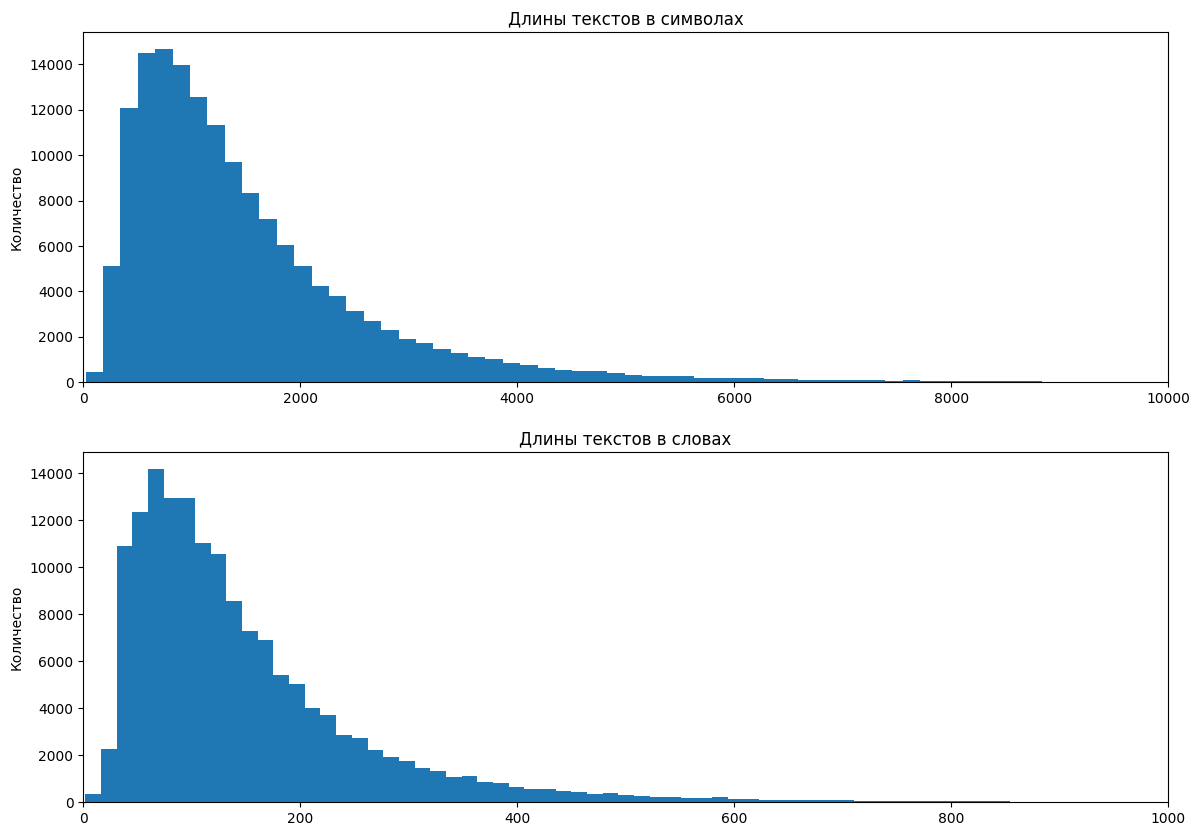

In [ ]:
fig, axes = plt.subplots(2, 1,figsize=(14,10))

axes[0].hist(ln_symbol, bins = 200)
axes[1].hist(ln_words, bins = 200)
axes[0].set_xlim(0, 10000)
axes[1].set_xlim(0, 1000)
axes[0].set_title('Длины текстов в символах')
axes[1].set_title('Длины текстов в словах')
axes[0].set_ylabel('Количество')
axes[1].set_ylabel('Количество')
fig.show()

### 1.3 Найдите 10 самых частых:
- слов

In [ ]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from collections import Counter
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

36766261


['Добрый',
 'день',
 'Я',
 'не',
 'являюсь',
 'клиентом',
 'банка',
 'и',
 'поручителем',
 'по']

In [ ]:
freq_dict = Counter(corpus)

# freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
freq_dict.most_common(10)

[('в', 1169557),
 ('и', 980761),
 ('не', 816419),
 ('на', 638715),
 ('что', 603171),
 ('я', 443478),
 ('с', 428021),
 ('по', 338743),
 ('мне', 293980),
 ('банка', 235175)]

- слов без стоп-слов

In [ ]:
stopword = stopwords.words('russian')
punkts = ['``', '...', "''", '""', '..', '....']
for val in punkts:
    stopword.append(val)

In [ ]:
corpus_without_stop = []
for word in tqdm(corpus):
    if word.lower() not in stopword:
        corpus_without_stop.append(word)
freq_dict = Counter(corpus_without_stop)
freq_dict.most_common(10)

100%|██████████| 36766261/36766261 [00:43<00:00, 840885.08it/s]


[('банка', 235175),
 ('банк', 159569),
 ('это', 158915),
 ('деньги', 121778),
 ('карту', 101181),
 ('карты', 99040),
 ('день', 74627),
 ('кредит', 71824),
 ('заявление', 65006),
 ('отделение', 63424)]

- лемм

In [ ]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 62.1 MB/s eta 0:00:00


In [ ]:
import pymorphy3
from pymorphy3 import MorphAnalyzer
pymorphy3_analyzer = MorphAnalyzer()

In [ ]:
morph = pymorphy3.MorphAnalyzer()

In [ ]:
lemmas = []
noun = []
for word in tqdm(corpus_without_stop):
    temp = morph.parse(word)[0]
    lemm = temp.normal_form
    lemmas.append(lemm)
    if temp.tag.POS == 'NOUN':
        noun.append(lemm)
freq_dict_lemm = Counter(lemmas)
freq_dict_lemm.most_common(10)

100%|██████████| 23470201/23470201 [33:04<00:00, 11828.80it/s]


[('банк', 624272),
 ('карта', 331815),
 ('это', 199740),
 ('деньга', 178338),
 ('день', 172634),
 ('мой', 167035),
 ('кредит', 154865),
 ('который', 148990),
 ('отделение', 143616),
 ('счёт', 140509)]

- существительных

In [ ]:
freq_dict_noun = Counter(noun)
freq_dict_noun.most_common(10)

[('банк', 624272),
 ('карта', 331815),
 ('деньга', 178338),
 ('день', 172634),
 ('кредит', 154865),
 ('отделение', 143616),
 ('счёт', 140509),
 ('сотрудник', 133662),
 ('клиент', 132908),
 ('сумма', 110914)]

### 1.4 Построить кривые Ципфа и Хипса

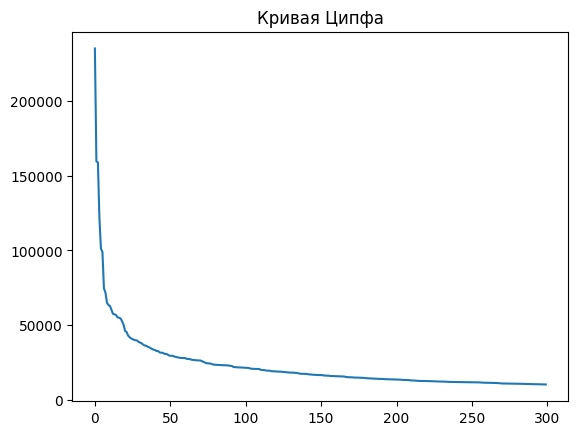

In [ ]:
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(range(300), freqs[:300])
ax.set_title(u'Кривая Ципфа', fontsize=12)
ax.set_title(u'Кривая Ципфа', fontsize=12)
plt.show()

In [ ]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|██████████| 153499/153499 [19:18<00:00, 132.53it/s]


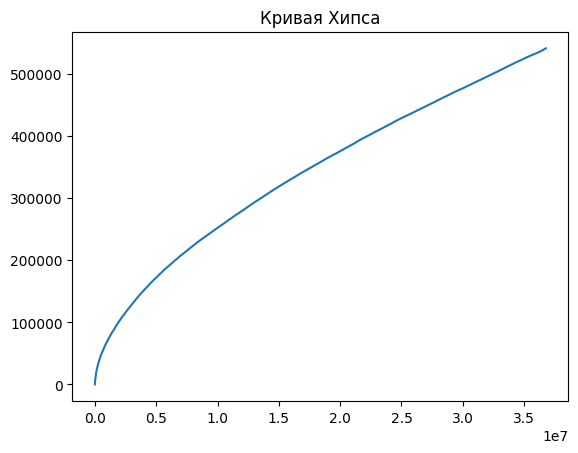

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
ax.set_title(u'Кривая Хипса', fontsize=12)
plt.show()

### 1.5 Ответить на следующие вопросы:

- какое слово встречается чаще, "сотрудник" или "клиент"?

- сколько раз встречается слова "мошенничество" и "доверие"?



Для ответа на опрос используем корпус с существительными из п.1.3

In [ ]:
for val in ["сотрудник", "клиент", "мошенничество", "доверие"]:
    print(val, freq_dict_noun.get(val))

сотрудник 133662
клиент 132908
мошенничество 3228
доверие 2098


**Вывод:** слово "мошенничество" встречается чаще, чем "доверие". Слова "сотрудник" и "клиент" встречаются почти с одной частотой: разница встречаемости этих слов 0.5%.

### 1.6 В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Использовать меру для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1).

Ключевые слова будем искать, используя ещё и признак 'title', так как в нём клиент кратко обозначает суть отзыва.

In [ ]:
mystopwords = stopwords.words('russian')

ru_words = re.compile("[А-Яа-я]+")


def get_top_word(bow, count_word = 10):
    '''
    Принимает на вход результат TfidfVectorizer.fit_transform.
    Возвращает список ключевых слов
    '''
    idx = np.ravel(bow.sum(axis=0).argsort(axis=1))[::-1][:count_word]
    top_words = np.array(vec.get_feature_names_out())[idx].tolist()
    return top_words


def words_only(text):
    return " ".join(ru_words.findall(text))

def lemmatize(text):
    try:
        return  " ".join([morph.parse(word)[0].normal_form for word in text.lower().split()])
    except:
        return " "

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [ ]:
# выполним на подвыборке данных 25% от датасета

df_mini = df.sample(frac=0.25)

In [ ]:
tqdm.pandas()

In [ ]:
df_mini.text = df_mini.text.astype('str').progress_apply(preprocess)

100%|██████████| 38375/38375 [17:54<00:00, 35.73it/s]


In [ ]:
df_mini.title = df_mini.title.astype('str').progress_apply(preprocess)

100%|██████████| 38375/38375 [00:21<00:00, 1813.47it/s]


In [ ]:
df_mini.head(5)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
15080,г. Ростов-на-Дону,False,пора отпуск,2,лицензия № 3251,artem2003,Промсвязьбанк,2015-02-03 14:40:00,сотрудничать псб рамка зарплатный проект г обр...,2.0
102778,г. Магнитогорск,False,бездействие работник банк,6,лицензия № 1961,eakam,Связной Банк,2012-08-22 10:28:00,год оплачивать отделение связный банк кредит с...,NaN
68139,г. Иваново,False,вечный должник,3,лицензия № 2766,Cors,ОТП Банк,2013-11-11 22:44:00,добрый день думать это читать значит довольный...,NaN
6042,г. Екатеринбург,False,постоянный сбой программа работа персонал,1,лицензия № 1481,ga-chernova,Сбербанк России,2015-04-11 20:56:00,время остальной банк пытаться развернуться лиц...,NaN
63555,г. Екатеринбург,False,помочь разрешить ситуация,1,лицензия № 2562,olenka_79,Бинбанк,2013-12-19 13:12:00,здравствуйте ваш банк довольный длительный вре...,5.0


In [ ]:
positive = df_mini[df_mini['rating_grade']==5]
negative = df_mini[df_mini['rating_grade']==1]

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 2), stop_words=stopword)
bow_title = vec.fit(df_mini['title'])
bow_text = vec.fit(df_mini['text'])

In [ ]:
bow_positive_title = bow_title.transform(positive['title'])
bow_positive_text = bow_text.transform(positive['text'])

In [ ]:
print('Ключевые слова и биграммы для title для положительных отзывов:')
get_top_word(bow_positive_title)

Ключевые слова и биграммы для title для положительных отзывов:


['благодарность',
 'банк',
 'отличный',
 'спасибо',
 'обслуживание',
 'хороший',
 'отличный банк',
 'ипотека',
 'довольный',
 'хороший банк']

In [ ]:
print('Ключевые слова и биграммы для text для положительных отзывов:')
get_top_word(bow_positive_text)

Ключевые слова и биграммы для text для положительных отзывов:


['банк',
 'карта',
 'очень',
 'всё',
 'вклад',
 'это',
 'кредит',
 'отделение',
 'клиент',
 'спасибо']

In [ ]:
bow_negative_title = bow_title.transform(negative['title'])
bow_negative_text = bow_text.transform(negative['text'])

In [ ]:
print('Ключевые слова и биграммы для title для отрицательных отзывов:')
get_top_word(bow_negative_title)

Ключевые слова и биграммы для title для отрицательных отзывов:


['банк',
 'карта',
 'деньга',
 'банкомат',
 'обслуживание',
 'сбербанк',
 'кредит',
 'отвратительный',
 'клиент',
 'вклад']

In [ ]:
print('Ключевые слова и биграммы для text для отрицательных отзывов:')
get_top_word(bow_negative_text)

Ключевые слова и биграммы для text для отрицательных отзывов:


['банк',
 'карта',
 'это',
 'деньга',
 'отделение',
 'кредит',
 'день',
 'заявление',
 'счёт',
 'сотрудник']

# Часть 2. Тематическое моделирование

### 1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [ ]:
!pip3 install gensim

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [ ]:
texts = [text.split() for text in df_mini.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Построим модели с различным числом тем: 5, 20

In [ ]:
from gensim.models import lsimodel, TfidfModel

In [ ]:
lsi_5 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)
lsi_5.show_topics(5)

[(0,
  '0.127*"-" + 0.117*"я" + 0.112*"мне" + 0.090*"меня" + 0.085*"деньги" + 0.084*"Я" + 0.081*"о" + 0.081*"все" + 0.081*"у" + 0.079*"за"'),
 (1,
  '-0.178*"-" + 0.146*"заявление" + 0.140*"г." + 0.124*"руб." + 0.116*"денежных" + 0.115*"средств" + 0.112*"000" + 0.110*"средства" + -0.110*"вклад" + 0.100*"денежные"'),
 (2,
  '-0.230*"звонки" + -0.181*"кредит" + 0.181*"деньги" + 0.174*"банкомат" + -0.167*"номер" + 0.157*"карту" + 0.144*"карты" + -0.129*"мой" + -0.103*"кредита" + -0.102*"телефона"'),
 (3,
  '-0.260*"номер" + 0.215*"кредит" + -0.176*"звонки" + 0.163*"000" + 0.157*"кредита" + 0.140*"руб." + 0.133*"сумму" + -0.123*"телефона" + -0.111*"мой" + 0.106*"сумма"'),
 (4,
  '0.183*"кредит" + -0.177*"вклад" + -0.171*"вклада" + -0.122*"средств" + 0.111*"сказали," + -0.110*"денежных" + 0.109*"мне" + -0.102*"–" + -0.098*"Банка" + 0.088*"сказала,"')]

In [ ]:
lsi_20 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=20)
lsi_20.show_topics(5)

[(0,
  '0.127*"-" + 0.117*"я" + 0.112*"мне" + 0.090*"меня" + 0.085*"деньги" + 0.084*"Я" + 0.081*"о" + 0.081*"все" + 0.081*"у" + 0.079*"за"'),
 (1,
  '-0.178*"-" + 0.145*"заявление" + 0.141*"г." + 0.124*"руб." + 0.116*"денежных" + 0.115*"средств" + 0.113*"000" + 0.109*"средства" + -0.108*"вклад" + 0.099*"размере"'),
 (2,
  '-0.230*"звонки" + -0.184*"кредит" + 0.178*"деньги" + 0.175*"банкомат" + -0.169*"номер" + 0.154*"карту" + 0.143*"карты" + -0.130*"мой" + -0.103*"телефона" + -0.103*"кредита"'),
 (3,
  '-0.259*"номер" + 0.212*"кредит" + -0.177*"звонки" + 0.160*"кредита" + 0.158*"000" + 0.138*"руб." + 0.135*"сумму" + -0.123*"телефона" + -0.109*"мой" + 0.106*"сумма"'),
 (4,
  '0.187*"кредит" + -0.177*"вклад" + -0.172*"вклада" + -0.116*"средств" + 0.111*"сказали," + 0.111*"мне" + -0.103*"денежных" + -0.101*"–" + -0.096*"Банка" + 0.089*"Я"')]

**Вывод:** для различного числа тем для моделей изменения коснулись только размера вклада тем. Получили понятные темы: карта, кредит, страховка, банкомат и тд.

### 2.2 Найти темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Проверим первые 20 отзывов на основе модели lsi_20 на наличие тем, связанных с конкретными банками.

In [ ]:
banks = ['сбербанк', 'альфа', 'втб', 'тинькофф']
responses = []

for idx in range(20):
    for response in lsi_20.show_topic(topicno=idx, topn=10):
        if response[0] in banks:
            responses.append([idx, lsi_20.show_topic(topicno=idx, topn=10)])

responses

[]

# Часть 3. Классификация текстов



### 3.1 Сформулировать для простоты задачу бинарной классификации: классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Используем датафреймы positive и negative, полученные в п.1.6, оставим в них только text

In [ ]:
data = pd.concat([positive, negative])

In [ ]:
X = data['text']
y = data['rating_grade']

In [ ]:
X.head()

,text
121817,"У меня в СМП счет ИП, карта и вклад, так что м..."
40363,Уважаемый Банк ВТБ24! Хотелось поблагодарить Б...
19803,Уважаемый Денис Робертович! Позвольте от всей ...
44329,Добрый день! Хочу поделиться мнением об обслуж...
133736,Я обслуживаюсь в Пробизнесбанке совсем недавн...


### 3.2 Составить обучающее и тестовое множество: выбрать из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Использовать sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 21)

### 3.3 Использовать любой известный алгоритм классификации текстов для решения задачи и получите baseline. Сравнить разные варианты векторизации текста: с использованием только униграм, пар или троек слов или с использованием символьных n-грамм

In [ ]:
def random_forest_n_gram(n, analyzer='word'):
    '''Принимает размер n-gram и строит модель'''
    vec = CountVectorizer(analyzer=analyzer, ngram_range=(n, n))
    bow = vec.fit_transform(X_train)

    model = RandomForestClassifier(random_state=21)
    model.fit(bow, y_train)

    pred = model.predict(vec.transform(X_test))
    print(classification_report(pred, y_test))

In [ ]:
print('Модель с использованием только униграмм')
random_forest_n_gram(1)

Модель с использованием только униграмм
              precision    recall  f1-score   support

         1.0       1.00      0.85      0.92      2742
         5.0       0.46      1.00      0.63       346

    accuracy                           0.87      3088
   macro avg       0.73      0.93      0.78      3088
weighted avg       0.94      0.87      0.89      3088



In [ ]:
print('Модель с использованием только биграмм')
random_forest_n_gram(2)

Модель с использованием только биграмм
              precision    recall  f1-score   support

         1.0       1.00      0.84      0.91      2791
         5.0       0.39      0.99      0.57       297

    accuracy                           0.85      3088
   macro avg       0.70      0.92      0.74      3088
weighted avg       0.94      0.85      0.88      3088



In [ ]:
print('Модель с использованием только триграмм')
random_forest_n_gram(3)

Модель с использованием только триграмм
              precision    recall  f1-score   support

         1.0       0.99      0.80      0.88      2919
         5.0       0.21      0.92      0.34       169

    accuracy                           0.80      3088
   macro avg       0.60      0.86      0.61      3088
weighted avg       0.95      0.80      0.85      3088



In [ ]:
print('Модель с использованием использованием символьных n-грамм')
random_forest_n_gram(1, analyzer='char')

Модель с использованием использованием символьных n-грамм
              precision    recall  f1-score   support

         1.0       0.98      0.80      0.88      2869
         5.0       0.23      0.80      0.36       219

    accuracy                           0.80      3088
   macro avg       0.61      0.80      0.62      3088
weighted avg       0.93      0.80      0.84      3088



Вывод: модели RandomForestClassifier на основе униграмм и биграмм на подвыборке показали примерно одинаковую точность 0.8

### 3.4 Сравнить, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

- преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD)

In [ ]:
model_tf_idf_TruncatedSVD = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD()),
    ('model', RandomForestClassifier())
])

In [ ]:
model_tf_idf_TruncatedSVD.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('tm', TruncatedSVD()), ('model', RandomForestClassifier())])

In [ ]:
truncatedsvd_pred = model_tf_idf_TruncatedSVD.predict(X_test)
print(classification_report(truncatedsvd_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.91      0.84      0.88      2537
         5.0       0.46      0.63      0.53       551

    accuracy                           0.80      3088
   macro avg       0.69      0.73      0.70      3088
weighted avg       0.83      0.80      0.81      3088



- тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [ ]:
model_tf_idf_LDA = Pipeline([
     ('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('model', RandomForestClassifier())
])

In [ ]:
model_tf_idf_LDA.fit(X_train, y_train)
lda_pred = model_tf_idf_LDA.predict(X_test)
print(classification_report(lda_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.96      0.90      0.93      2501
         5.0       0.67      0.85      0.75       587

    accuracy                           0.89      3088
   macro avg       0.81      0.87      0.84      3088
weighted avg       0.91      0.89      0.90      3088



Вывод: классификация текстов на основе LDA показала куда более высокую точность 0.89 по сравнению с моделью на основе сингулярного разложения TruncatedSVD 0.8

### Выводы

В работе были рассмотрены различные аспекты классификации по тональности отзывов на банки: анализ основных характеристик, тематическое моделирование и классификация на основе классической модели RandomForestClassifier с использованием TruncatedSVD и LDA.

Модель классификации на подвыборке на основе LDA показал хорошую точность 0.89, при этом он превышает по скорости классическую модель RandomForestClassifier.